In [76]:
import pickle
from random import shuffle, seed
import numpy as np
from util import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore') # get rid of silly sklearn warnings

seed("sahai uwu")

In [78]:
#ppath = "/Volumes/scottf/mimic_processed/preproced.bin"
ppath = "/Volumes/scottf/mimic_processed/preproced_neg.bin"
#;l .ppath = "/Volumes/scottf/mimic_processed/preproced_discharge.bin"
data = pickle.load(open(ppath, 'rb')) # Tuples of (text, label) where label is 0 or 1
shuffle(data)

split_point = int(0.8 * len(data)) # Use 80% of our data for training and the rest for testing
train = data[:split_point]
test = data[split_point:]

train_data = [t[0] for t in train]
train_labels = [t[1] for t in train]
test_data = [t[0] for t in test]
test_labels = [t[1] for t in test]

print("Number of training samples: " + str(len(train)))
print("Number of test samples: " + str(len(test)))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

Number of training samples: 5361
Number of test samples: 1341
(array([0, 1]), array([3070, 2291]))
(array([0, 1]), array([787, 554]))


[0.8959149412423055, 0.9018839768699869, 0.9015109121432568, 0.9024435739600821, 0.9052415594105577, 0.9076664801343033, 0.9072934154075732, 0.9091587390412237, 0.9102779332214139, 0.9123297892184294, 0.9134489833986197, 0.9115836597649692, 0.9130759186718895, 0.9143816452154448, 0.914754709942175, 0.9156873717590002, 0.914754709942175, 0.9156873717590002, 0.9166200335758254, 0.9186718895728408, 0.9184853572094759, 0.919231486662936, 0.9207237455698564, 0.9214698750233166, 0.923335198656967, 0.9225890692035068, 0.9240813281104272, 0.9229621339302368, 0.923335198656967, 0.9235217310203321, 0.9246409252005223, 0.9257601193807126, 0.9263197164708077, 0.9274389106509979, 0.9268793135609028, 0.9278119753777281, 0.9272523782876329, 0.927625443014363, 0.9287446371945532, 0.9296772990113785, 0.9306099608282037, 0.9326618168252192, 0.9317291550083939, 0.931915687371759, 0.9330348815519492, 0.9337810110054094, 0.9341540757321395, 0.9350867375489648, 0.9356463346390599, 0.935832867002425]
[0.9008

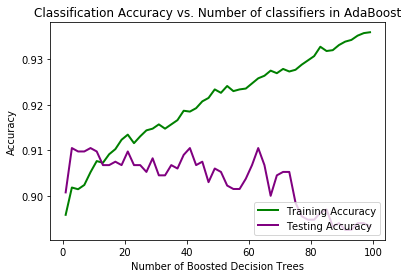

In [59]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

gridSearch = False
if gridSearch:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier())
    params = {'adaboostclassifier__n_estimators' : [32, 64], 'countvectorizer__ngram_range' : [(1, 1), (1, 2), (2, 2)]}
    clf = GridSearchCV(classifier, params, n_jobs=-1)
else:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier(n_estimators=100)) 
    clf = classifier

clf.fit(train_data, train_labels)

def confs(estimator, data):
    class_probs = estimator.predict_proba(data)
    confs = [c[1] for c in class_probs]
    return confs

def transforms(pipeline, X):
    """Applies all transforms to the data, without applying last 
       estimator.
    """
    Xt = X
    for name, transform in pipeline.steps[:-1]:
        Xt = transform.transform(Xt)
    return Xt

def weighted_vote(estimators, weights, data):
    #print("Data " + str(data.shape))
    preds = np.array([confs(e, data) for e in estimators])
    #print("Preds " + str(preds.shape) + " " + str(preds))
    #print("Weights " + str(weights.shape))
    weighted_preds = np.average(preds, axis=0, weights=weights)
    #print("Weighted Preds " + str(weighted_preds.shape) + " " + str(weighted_preds))
    return np.around(weighted_preds)

# Plot accuracy vs number of estimators
train_accs = []
test_accs = []
trans_test = transforms(clf, test_data)
trans_train = transforms(clf, train_data)
for i in range(1, len(clf.named_steps['adaboostclassifier'].estimators_), 2):
    preds = weighted_vote(clf.named_steps['adaboostclassifier'].estimators_[:i], clf.named_steps['adaboostclassifier'].estimator_weights_[:i], trans_test)
    test_accs.append(np.mean(preds == test_labels))
    preds = weighted_vote(clf.named_steps['adaboostclassifier'].estimators_[:i], clf.named_steps['adaboostclassifier'].estimator_weights_[:i], trans_train)
    train_accs.append(np.mean(preds == train_labels))
    
print(train_accs)
print(test_accs)

plt.figure()
lw = 2
plt.plot(range(1, len(clf.named_steps['adaboostclassifier'].estimators_), 2), train_accs, color='green',
         lw=lw, label='Training Accuracy')
plt.plot(range(1, len(clf.named_steps['adaboostclassifier'].estimators_), 2), test_accs, color='purple',
         lw=lw, label='Testing Accuracy')
plt.xlabel('Number of Boosted Decision Trees')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Number of classifiers in AdaBoost')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ada_num_class.png')

Accuracy: 0.9090231170768084


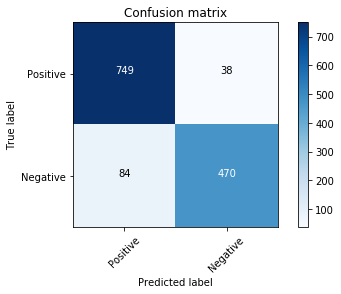

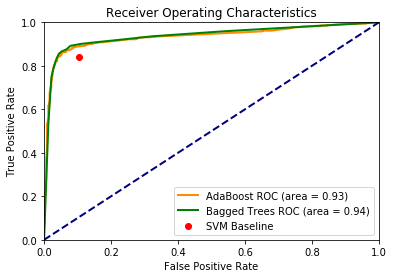

In [79]:
bagged_fpr = [0.,0.0128866,0.02190722,0.03092784,0.03737113,0.04381443, 0.05154639,0.06701031,0.07860825,0.10953608,0.1507732,0.21778351,0.32603093,0.53994845,1.]
bagged_tpr = [0., 0.53628319, 0.74867257, 0.80530973, 0.83362832, 0.85486726, 0.86548673, 0.87610619, 0.8920354, 0.90088496, 0.9079646,  0.91858407, 0.93628319, 0.95929204, 1.]
bagged_roc_auc = 0.94

clf = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier(n_estimators=40)) 
clf.fit(train_data, train_labels)

predictions = clf.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = clf.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AdaBoost ROC (area = %0.2f)' % roc_auc)
plt.plot(bagged_fpr, bagged_tpr, color='green',
         lw=lw, label='Bagged Trees ROC (area = %0.2f)' % bagged_roc_auc)
plt.scatter([0.10292249047013977], [0.8411552346570397], color="red", label="SVM Baseline")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

[0. 0. 0. ... 0. 0. 0.]
['hyperbilirubinemia', 'placement_indication', 'ferrous_sulfate', 'hyperbilirubinemia_dictated', 'job', 'bili', 'physiologic_jaundice', 'notable', 'phototherapy', 'bed', 'rebound', 'rr', 'photorx', 'rebound_bilirubin', 'level', 'dstik', 'asp', 'pale_pink', 'exhibited', 'afof']
['fenalt' 'fenbegin' 'fenbaby' 'fenale' 'fenadvancement' 'fenbw'
 'fenadvanced' 'fenadlib' 'fenad' 'fenbw_gm' 'fenbwg' 'fenabs' 'fenabd'
 'fenatnyl_drip' 'appropriate' 'hyperbili' 'comfortable' 'bilirubin'
 'vital_signs' 'mild_intsc' 'midline_structures' 'bs' 'waking' 'included'
 'palate_intact' 'hc_gain' 'mild_subcoastal' 'head' 'deferred' 'wk_respr'
 'afof' 'exhibited' 'pale_pink' 'asp' 'dstik' 'level' 'rebound_bilirubin'
 'photorx' 'rr' 'rebound' 'bed' 'phototherapy' 'notable'
 'physiologic_jaundice' 'bili' 'job' 'hyperbilirubinemia_dictated'
 'ferrous_sulfate' 'placement_indication' 'hyperbilirubinemia']


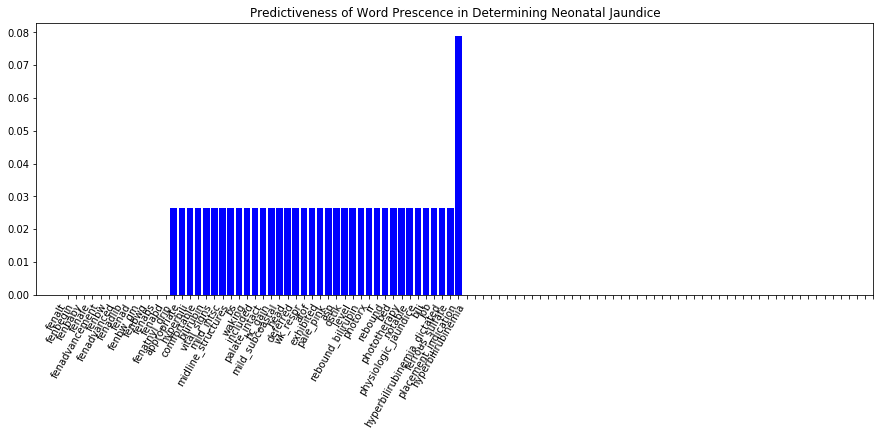

In [51]:
print(clf.named_steps['adaboostclassifier'].feature_importances_)
top_features_indices = np.argsort(clf.named_steps['adaboostclassifier'].feature_importances_)[::-1]
sorted_features_names = [clf.named_steps['countvectorizer'].get_feature_names()[i] for i in top_features_indices[:20]]
sorted_feature_importances = [clf.named_steps['adaboostclassifier'].feature_importances_[i] for i in top_features_indices[:20]]
print(sorted_features_names)

def plot_coefficients(coef, feature_names, top_features=50):
    top_coefficients = np.argsort(coef)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    print(feature_names[top_coefficients])
    plt.title('Predictiveness of Word Prescence in Determining Neonatal Jaundice')
    plt.savefig("ada_predictiveness.png")
    plt.show()
    
plot_coefficients(clf.named_steps['adaboostclassifier'].feature_importances_, clf.named_steps['countvectorizer'].get_feature_names())

In [52]:
scores = cross_val_score(clf, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()

0.9064887018440027

In [73]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

clf = make_pipeline(CountVectorizer(), TfidfTransformer(), AdaBoostClassifier(n_estimators=40)) 
clf.fit(train_data, train_labels)

predictions = clf.predict(test_data)

print("Accuracy: " + str(accuracy_score(test_labels, predictions)))
p, r, f, _ = precision_recall_fscore_support(test_labels, predictions)
print("Precision: " + str(p))
print("Recall: " + str(r))
print("F1: " + str(f))

Accuracy: 0.8593350383631714
Precision: [0.77256318 0.90693069]
Recall: [0.81992337 0.87907869]
F1: [0.79553903 0.89278752]
